# What this script does ?

This notebook is used to calculate representative days used in the EPM model. The script is divided into 4 parts:
1. Extract renewables generation data from Ninja API.
2. Calculate representative year among historical data.
3. Calculate special and representatative days within this year.
4. Export pHours, pVREgen in EPM format.

It is based on previously developed GAMS code for the Poncelet algorithm. The objective has been to automate the process and make it more user-friendly.
The code will automatically get the min production for PV, the min production for Wind, and the max load days for each season, called the special days.
It will automatically removes the special days from the input file for the Poncelet algorithm and then runs the Poncelet algorithm to generate the representative days.

# Installation
It's recommended to install a conda environment based on the `requirements.txt` file to run this script.
In order to do so, you can run the following command in your terminal: 
```bash
conda create --name myenv --file requirements.txt
```
If there are some dependencies issues because some package are not included (project is still under construction) in the `requirements.txt` file, install them manually. 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from utils import *

/Users/celia/Documents/WorldBank/Energy_planning/SAPP_2025/Data/Planning-tools/utils.py:711: SyntaxWarning: invalid escape sequence '\{'
  path_main_file = os.path.join(os.getcwd(), f'gams\{gams_model}.gms')
/Users/celia/Documents/WorldBank/Energy_planning/SAPP_2025/Data/Planning-tools/utils.py:712: SyntaxWarning: invalid escape sequence '\{'
  path_setting_file = os.path.join(os.getcwd(), f'gams\{bins_settings}.csv')


# User input parameters (to manually change)

User needs to change the following parameters in the following cell:
1. `name_data` : Name of the folder where data will be saved.
2. `extract_renewables` : Whether to extract renewables data from Ninja API or not. If False, the script will use the data file provided by the user. Please note that dowloading data from Ninja API is time consuming, so do it only once. Also, there are API limits on the hourly number of downloads, so it is better to download the data once and use it multiple times.
3. `locations` : Coordinates of the location for which the data is to be extracted. The format is (latitude, longitude).
4. `power_types` : Types of power for which the data is to be extracted. The format is ['solar', 'wind'].
5. `start_year` : Start year of the historical data.
6. `end_year` : End year of the historical data.

You should also update the `API_TOKEN` in `utils.py` by creating an account in Renewable Ninja. This will allow you to increase the number of requests per hour. This process is explained in the documentation of renewable ninja.

We provide two examples, one for a country model, one for a regional model. The country example is based on data that was provided by the utility, the regional example is based on data that was downloaded from renewable ninja.

In [9]:
### COUNTRY EXAMPLE

name_data = 'south_africa' # Name of the zone, used to name the folder where the data is stored
main_folder = os.path.join('data', name_data)
if not os.path.exists(main_folder):
    os.makedirs(main_folder)

extract_renewables = {'solar': True, 'wind': True} # Set to True to extract data from Renewables Ninja

# If extract_renewables is True, fill the following variables
locations = {
    'solar': {
        'southafrica': (-30.5595, 22.9375)
    },
    'wind': {
        'southafrica': (-30.5595, 22.9375)
    }  
}

power_types = list(locations.keys()) # 'wind' or 'solar'

start_year = 2023 # earliest year is 1980
end_year = 2024


In [2]:
### REGION EXAMPLE

name_data = 'sapp' # Name of the zone, used to name the folder where the data is stored
main_folder = os.path.join('data', name_data)
if not os.path.exists(main_folder):
    os.makedirs(main_folder)

extract_renewables = {'solar': True, 'wind': True} # Set to True to extract data from Renewables Ninja

# If extract_renewables is True, fill the following variables
locations = {
    'solar': {
        'southafrica': (-29.35, 19.0),
        'zimbabwe': (-20.38, 27.86),
        'zambia': (-15.15, 27.95),
        'tanzania': (-4, 33.75),
        'namibia': (-24.97, 17.78),
        'mozambique': (-16.0, 32.22),
        'malawi': (-13.09, 34.25),
        'lesotho': (-29.10, 27.81),
        'eswatini': (-26.48, 30.86),
        'DRC': (-0.78, 22.89),
        'DRCSouth': (-9.66, 26.19),
        'botswana': (-21.16, 25.40),
        'angola': (-17.02, 18.58)
    },
    'wind': {
        'southafrica': (-31.66, 22.13),
        'zimbabwe': (-18.8, 29.3),
        'zambia': (-15.74, 27.94),
        'tanzania': (-4.91, 34.64),
        'namibia': (-27.61, 18.05),
        'mozambique': (-16.59, 33.42),
        'malawi': (-11.90, 33.46),
        'lesotho': (-29.9, 27.27),
        'eswatini': (-26.45, 31.91),
        'DRC': (2.76, 29.26),
        'DRCSouth': (-8.73, 25.08),
        'botswana': (-21.06, 24.91),
        'angola': (-15.62, 14.73)
    }  
}

power_types = list(locations.keys()) # 'wind' or 'solar'

start_year = 2023 # earliest year is 1980
end_year = 2024


## Create the folder structure

The following cell creates the folder structure required for the script to run.
1. The `main_folder` is `data/name_data/`.
2. In `data/name_data/raw_data/`, the raw data is stored, including the data from Ninja API.
3. In `data/name_data/repr_days/`, the representative days are stored, as well as some auxiliary files.

In [3]:
folder_raw_data = os.path.join(main_folder, 'raw_data')
# Make folder
if not os.path.exists(folder_raw_data):
    os.makedirs(folder_raw_data)
    
main_folder = os.path.join(main_folder, 'repr_days')
if not os.path.exists(main_folder):
    os.makedirs(main_folder)

# 1. Extract data from Renewables Ninja

Depends on the `extract_renewables` parameter, the script will extract the data from the Ninja API or use the data file provided by the user.

In [4]:
for power_type in power_types:
    if extract_renewables[power_type]:
        locations_power = locations[power_type]
        get_years_renewables(locations=locations_power, power_type=power_type, start_year=start_year, 
                            end_year=end_year, name_data=name_data, output=folder_raw_data)

/Users/celia/miniforge3/envs/epm/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.renewables.ninja'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting data solar for year 2023


/Users/celia/miniforge3/envs/epm/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.renewables.ninja'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting data wind for year 2023


## Process renewable ninja data to group by season
Renewable ninja ata is processed to group months into season, to be used as input to EPM. This step may be skipped if one wishes to keep the seasonal definition at the monthly scale, or updated based on the seasonal grouping that makes the most sense for the case study at hand.

### Explore data
You may want to explore patterns in the extracted data, to decide how to group months into seasons for instance.

In [18]:
filenames = {'PV': [os.path.join(folder_raw_data, 'data_{}_solar.csv'.format(name_data)), 'renewable_ninja'],
             'Wind': [os.path.join(folder_raw_data, 'data_{}_wind.csv'.format(name_data)), 'renewable_ninja'],
             }

# Test data - for illustration purposes only
filenames = {'PV': [os.path.join('data_test', 'regional', 'data_{}_solar_season.csv'.format(name_data)), 'renewable_ninja'],
             'Wind': [os.path.join('data_test', 'regional', 'data_{}_wind_season.csv'.format(name_data)), 'renewable_ninja'],
             }

location_map = {v: k for tech in locations.values() for k, v in tech.items()}

df_energy = format_data_energy(filenames, locations=location_map)

Representative year 2022
Annual capacity factor (%): tech         zone        PV      Wind
0             DRC  0.135872  0.085138
1        DRCSouth  0.177508  0.246418
2          angola  0.206059  0.265434
3        botswana  0.214726  0.470406
4        eswatini  0.208684  0.392075
5         lesotho  0.220973  0.326241
6          malawi  0.192234  0.460542
7      mozambique  0.196332  0.464603
8         namibia  0.228657  0.446171
9     southafrica  0.226761  0.521873
10       tanzania  0.190114  0.525714
11         zambia  0.200370  0.453931
12       zimbabwe  0.217439  0.422827


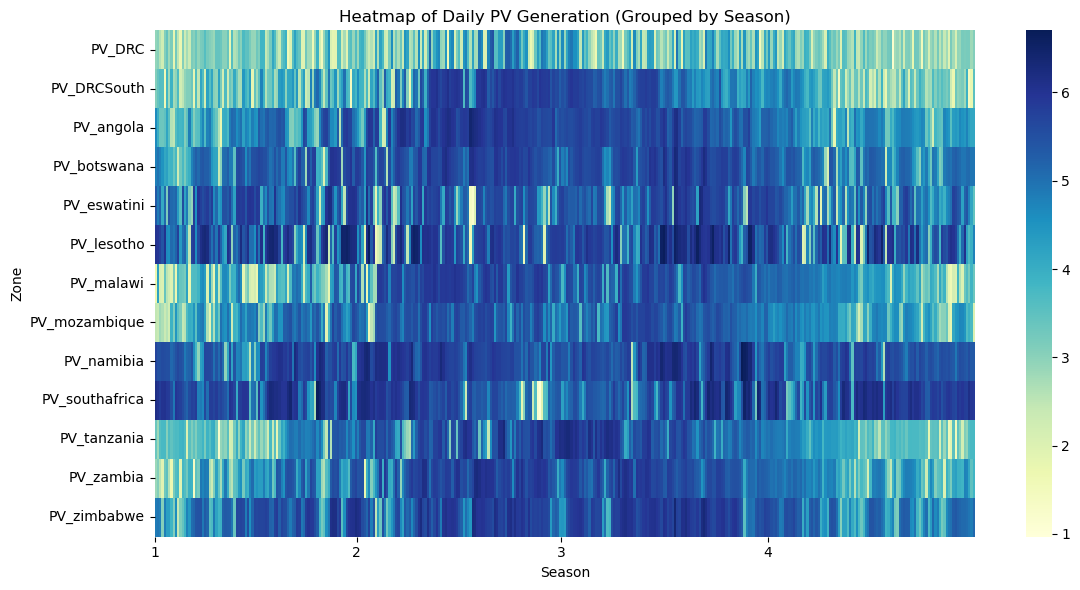

In [19]:
make_heatmap(df_energy, tech='PV')

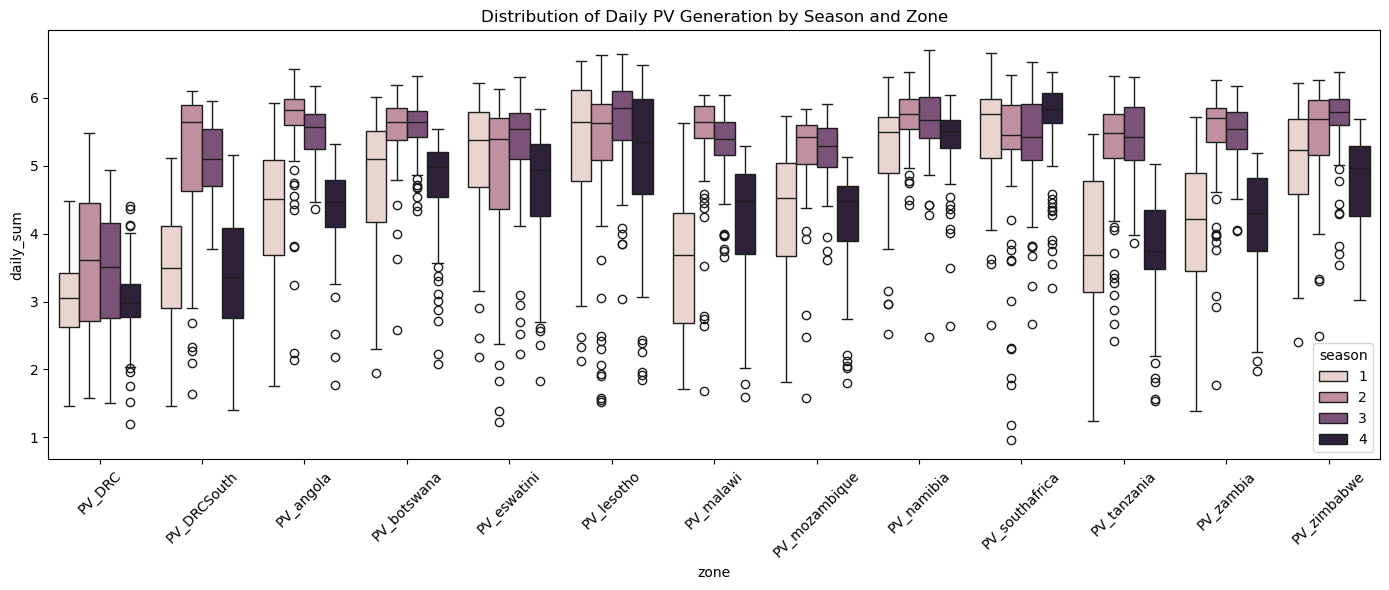

In [20]:
make_boxplot(df_energy, tech='PV')

### Group months into seasons

In [6]:
seasons_dict = {
    1: 1,
    2: 1,
    3: 1,
    4: 2,
    5: 2,
    6: 2,
    7: 3,
    8: 3,
    9: 3,
    10: 4,
    11: 4,
    12: 4
}  # grouping months into 4 seasons, to define according to user

filenames = {'PV': [os.path.join(folder_raw_data, 'data_{}_solar.csv'.format(name_data)), 'renewable_ninja'],
             'Wind': [os.path.join(folder_raw_data, 'data_{}_wind.csv'.format(name_data)), 'renewable_ninja']
             }

for key, filename in filenames.items():
    data = pd.read_csv(filename[0], index_col=False)
    data = data.rename(columns={'season': 'month'})
    data['season'] = data.apply(lambda row: seasons_dict[row['month']], axis=1)
    data = data.sort_values(by=['season', 'month', 'day', 'hour'])
    data = data[~((data['month'] == 2) & (data['day'] == 29))]
    # Renumber days sequentially within each season
    data['season_day'] = data.groupby(['latitude', 'longitude', 'season']).cumcount() // 24 + 1

    data = data.drop(columns=['day']).rename(columns={'season_day': 'day'})
    data = data.set_index(['latitude', 'longitude', 'season', 'day', 'hour']).reset_index().drop(columns=['month'])
    data = data.sort_values(by=['latitude', 'longitude', 'season', 'day', 'hour'])
    data.to_csv(f'{filename[0].split('.csv')[0]}_season.csv', float_format='%.4f', index=False)

# 2. Process data

Here, you need to specifiy the location of the data file. The script will process the data and calculate the representative year.
For `Load` data that is typically not available in the Ninja API, user need to provide a `.csv` file with columns `zone`, `season`, `day`, `hour`.
The data should have a header with the columns names as well as 8760 rows for each hour of the year. 

The script can handle multiple columns that are considered different load years, and will calculate the representative year to start the algorithm.
The script can also handle multiple zones (ongoing development !). 

## Input parameters

**User-defined parameters** 

User needs to change the following parameters in the following cell:

1. `nbr_days`: Defines the number of representative days used in the Poncelet algorithm.
2. Elements in `filenames`: Specify whether the input data should be treated as standard or renewable_ninja, depending on its source and formatting.
3. `n_clusters`: Only relevant if the clustering method is used. Specifies the number of clusters (i.e., representative days) to generate.
4. `settings.csv` file: This file defines the level of detail in the Poncelet algorithm. A higher number of zones or time series increases numerical complexity. Start with settings_bins10.csv (fewer bins) for easier computation. Increase the number of bins progressively if the problem remains easy to solve.
5. `n_features_selection` (optional): This enables automatic feature selection to reduce the number of time series used. It is useful when working with a large number of countries or zones, which can lead to a high number of pairwise correlations and significantly increase computational time. Use this option if the Poncelet algorithm becomes too slow to solve (e.g., more than a few minutes).

**Data formatting** 
Proper formatting of input data is essential for seamless integration into the model. Please follow these guidelines:

**Renewable Ninja Data**:

If the data is extracted through this code, the formatting will be correct by default. The specification renewable_ninja should be specified in the filenames to indicate that the data originates from Renewable Ninja.

**User-Specific Data**:

Example: capacity factors derived from actual production data provided by the client, or load demand provided by the utility. Users are responsible for ensuring that the data is formatted correctly. Reference examples are available in the data_test folder. The required columns are zone, season, day, hour, , , ... In this case, the specification standard should be specified in the filenames to indicate that the data is formatted in the standard way.

## Special days methodology
1. **Classical methodology**

This method selects a few special days—typically those with:
- Minimum PV production
- Minimum wind production
- Maximum electricity load

These days are assigned a weight of 1 in the final selected days. As a result, their impact on model results is generally limited — unless they reflect extreme conditions combined with a high Value of Lost Load (VOLL).

2. **Clustering-Based Method (Ongoing)**
To increase the influence of extreme days on the model, a second approach is under development. It proceeds as follows:
- Clustering: All days are grouped into k clusters using K-Means, and based on the features (VRE production and load).
- Selection of Extremes: Days with the lowest PV, lowest wind, and highest load are identified as special days. For multi-zone cases, total daily PV or wind production across all zones is used.
- Cluster Exclusion and Weight: 
    - The entire cluster containing each extreme day is excluded from the main dataset.
    - The centroid (i.e., most representative day) of each excluded cluster is then included as a special day.
    - This day is assigned a weight equal to the cluster’s share of the original dataset.

This method ensures that days with system stress (e.g., low renewable production) have a greater impact on optimization results through the higher weight.

**Important Note**:
This methodology is still in development and should only be used by users familiar with its implications. 


### Classical methodology

In [4]:


# Example with data not obtained from renewable ninja, but from user-specific processing. In this case, one should pay attention to how VRE and load data should be formatted.
# Examples are given in the data_test folder.
filenames = {'PV': [os.path.join('data_test', 'data_{}_solar.csv'.format(name_data)), 'standard'],
             'Wind': [os.path.join('data_test', 'data_{}_wind.csv'.format(name_data)), 'standard'],
             'Load': [os.path.join('data_test', 'data_south_africa_load.csv'), 'standard']
             }

# Regional example, with data taken from renewable ninja.
filenames = {'PV': [os.path.join(folder_raw_data, 'data_{}_solar_season.csv'.format(name_data)), 'renewable_ninja'],
             'Wind': [os.path.join(folder_raw_data, 'data_{}_wind_season.csv'.format(name_data)), 'renewable_ninja'],
             # 'Load': [os.path.join('data_test', 'data_south_africa_load.csv'), 'standard']
             }

location_map = {v: k for tech in locations.values() for k, v in tech.items()}
            

Here, all the data is processed and the representative year is calculated in one cell !

In [5]:
# Read, select representative year and format the data from .csv files
df_energy = format_data_energy(filenames, locations=location_map)

# Find special days and remove them
special_days = find_special_days(df_energy, columns=[i for i in df_energy.columns if i not in ['season', 'day', 'hour']])

print('Number of hours in the year:', len(df_energy))

# Remove the special days from the data
df_energy_no_special = removed_special_days(df_energy, special_days)
print('Number of hours in the year:', len(df_energy_no_special))
print('Removed days:', (len(df_energy) - len(df_energy_no_special)) / 24)

# Format the data (including correlation calculation) and save it in a .csv file
_, path_data_file = format_optim_repr_days(df_energy_no_special, name_data, main_folder)

# Feature selection is optional but recommended if you are working with a large number of zones or time series. This reduces the number of pairwise correlations and helps avoid high computational complexity in the optimization step.
n_features_selection = 30

selected_series, df, path_data_file_selection = (
    select_representative_series_hierarchical(path_data_file, n=n_features_selection, method='ward', metric='euclidean', scale=True, scale_method='standard'))

# Launch the optimization to find the representative days. 

nbr_days = 2
path_data = path_data_file  # you want to include all the features to identify representative days
path_data = path_data_file_selection  # you only want to work with the reduced number of features to identify representative days
launch_optim_repr_days(path_data, main_folder, nbr_days=nbr_days, bins_settings='settings_bins10', gams_model='OptimizationModelZone')


# Get the results
repr_days = parse_repr_days(main_folder, special_days)
# Format the data to be used in EPM
format_epm_phours(repr_days, main_folder, name_data=name_data)
format_epm_pvreprofile(df_energy, repr_days, main_folder, name_data=name_data)
# format_epm_demandprofile(df_energy, repr_days, main_folder, name_data=name_data)  # only activate when load data is provided

Representative year 2022
Annual capacity factor (%): tech         zone        PV      Wind
0             DRC  0.135872  0.085138
1        DRCSouth  0.177508  0.246418
2          angola  0.206059  0.265434
3        botswana  0.214726  0.470406
4        eswatini  0.208684  0.392075
5         lesotho  0.220973  0.326241
6          malawi  0.192234  0.460542
7      mozambique  0.196332  0.464603
8         namibia  0.228657  0.446171
9     southafrica  0.226761  0.521873
10       tanzania  0.190114  0.525714
11         zambia  0.200370  0.453931
12       zimbabwe  0.217439  0.422827
Number of hours in the year: 8760
Number of hours in the year: 8568
Removed days: 8.0
File saved at: data/sapp/repr_days/data_formatted_optim_sapp.csv
File saved at: /Users/celia/Documents/WorldBank/Energy_planning/SAPP_2025/Data/Planning-tools/data/sapp/repr_days/data_formatted_optim_sapp_selection.csv
/Users/celia/Documents/WorldBank/Energy_planning/SAPP_2025/Data/Planning-tools/gams/OptimizationModelZone.gms 

/Users/celia/Documents/WorldBank/Energy_planning/SAPP_2025/Data/Planning-tools/utils.py:862: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pVREProfile = pVREProfile.stack(level=['fuel', 'zone'])


### Methodology with clustering to handle special days


In [8]:
filenames = {'PV': [os.path.join(folder_raw_data, 'data_{}_solar_season.csv'.format(name_data)), 'renewable_ninja'],
             'Wind': [os.path.join(folder_raw_data, 'data_{}_wind_season.csv'.format(name_data)), 'renewable_ninja'],
             # 'Load': [os.path.join('data_test', 'data_south_africa_load.csv'), 'standard']
             }

location_map = {v: k for tech in locations.values() for k, v in tech.items()}

# Clustering the data to extract clusters corresponding to extreme conditions
n_clusters = 20

df_energy = format_data_energy(filenames, locations=location_map)
df_energy_cluster, df_closest_days, centroids_df = cluster_data_new(df_energy, n_clusters=n_clusters)

# Extracting special days as centroids of the extreme clusters
special_days, df_energy_no_special = get_special_days_clustering(df_closest_days, 
                                                                 df_energy_cluster, threshold=0.1)

print('Number of hours in the year:', len(df_energy_no_special))
print('Removed days:', (len(df_energy) - len(df_energy_no_special)) / 24)

# Format the data (including correlation calculation) and save it in a .csv file
_, path_data_file = format_optim_repr_days(df_energy_no_special, name_data, main_folder)

# Feature selection is optional but recommended if you are working with a large number of zones or time series. This reduces the number of pairwise correlations and helps avoid high computational complexity in the optimization step.
n_features_selection = 30

selected_series, df, path_data_file_selection = (
    select_representative_series_hierarchical(path_data_file, n=n_features_selection, method='ward', metric='euclidean', scale=True, scale_method='standard'))

# Launch the optimization to find the representative days
n_rep_days = 2
path_data = path_data_file  # you want to include all the features to identify representative days
path_data = path_data_file_selection  # you only want to work with the reduced number of features to identify representative days

launch_optim_repr_days(path_data, main_folder, nbr_days=n_rep_days, gams_model='OptimizationModelZone',
                       bins_settings='settings_bins10')

# Get the results
repr_days = parse_repr_days(main_folder, special_days)

# Format the data to be used in EPM
format_epm_phours(repr_days, main_folder, name_data=name_data)
format_epm_pvreprofile(df_energy, repr_days, main_folder, name_data=name_data)
# format_epm_demandprofile(df_energy, repr_days, main_folder, name_data=name_data)  # only activate when load data is provided

Representative year 2022
Annual capacity factor (%): tech         zone        PV      Wind
0             DRC  0.135872  0.085138
1        DRCSouth  0.177508  0.246418
2          angola  0.206059  0.265434
3        botswana  0.214726  0.470406
4        eswatini  0.208684  0.392075
5         lesotho  0.220973  0.326241
6          malawi  0.192234  0.460542
7      mozambique  0.196332  0.464603
8         namibia  0.228657  0.446171
9     southafrica  0.226761  0.521873
10       tanzania  0.190114  0.525714
11         zambia  0.200370  0.453931
12       zimbabwe  0.217439  0.422827
Number of hours in the year: 8040
Removed days: 30.0
File saved at: data/sapp/repr_days/data_formatted_optim_sapp.csv
File saved at: /Users/celia/Documents/WorldBank/Energy_planning/SAPP_2025/Data/Planning-tools/data/sapp/repr_days/data_formatted_optim_sapp_selection.csv
/Users/celia/Documents/WorldBank/Energy_planning/SAPP_2025/Data/Planning-tools/gams/OptimizationModelZone.gms /Users/celia/Documents/WorldBank/

/Users/celia/Documents/WorldBank/Energy_planning/SAPP_2025/Data/Planning-tools/utils.py:862: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pVREProfile = pVREProfile.stack(level=['fuel', 'zone'])


## Plot results 

Optional cell to plot the results. It will plot the load, wind and solar data for the representative year.

In [6]:
# Get data 
input_file = pd.read_csv(os.path.join(main_folder, 'data_formatted_optim_{}.csv'.format(name_data)), index_col=[0,1,2])
input_file.index.names = ['season', 'day', 'hour']

VREProfile = pd.read_csv(os.path.join(main_folder, 'pVREProfile_{}.csv'.format(name_data)), index_col=[0,1,2,3])

pHours = pd.read_csv(os.path.join(main_folder, 'pHours_{}.csv'.format(name_data)), index_col=[0,1])

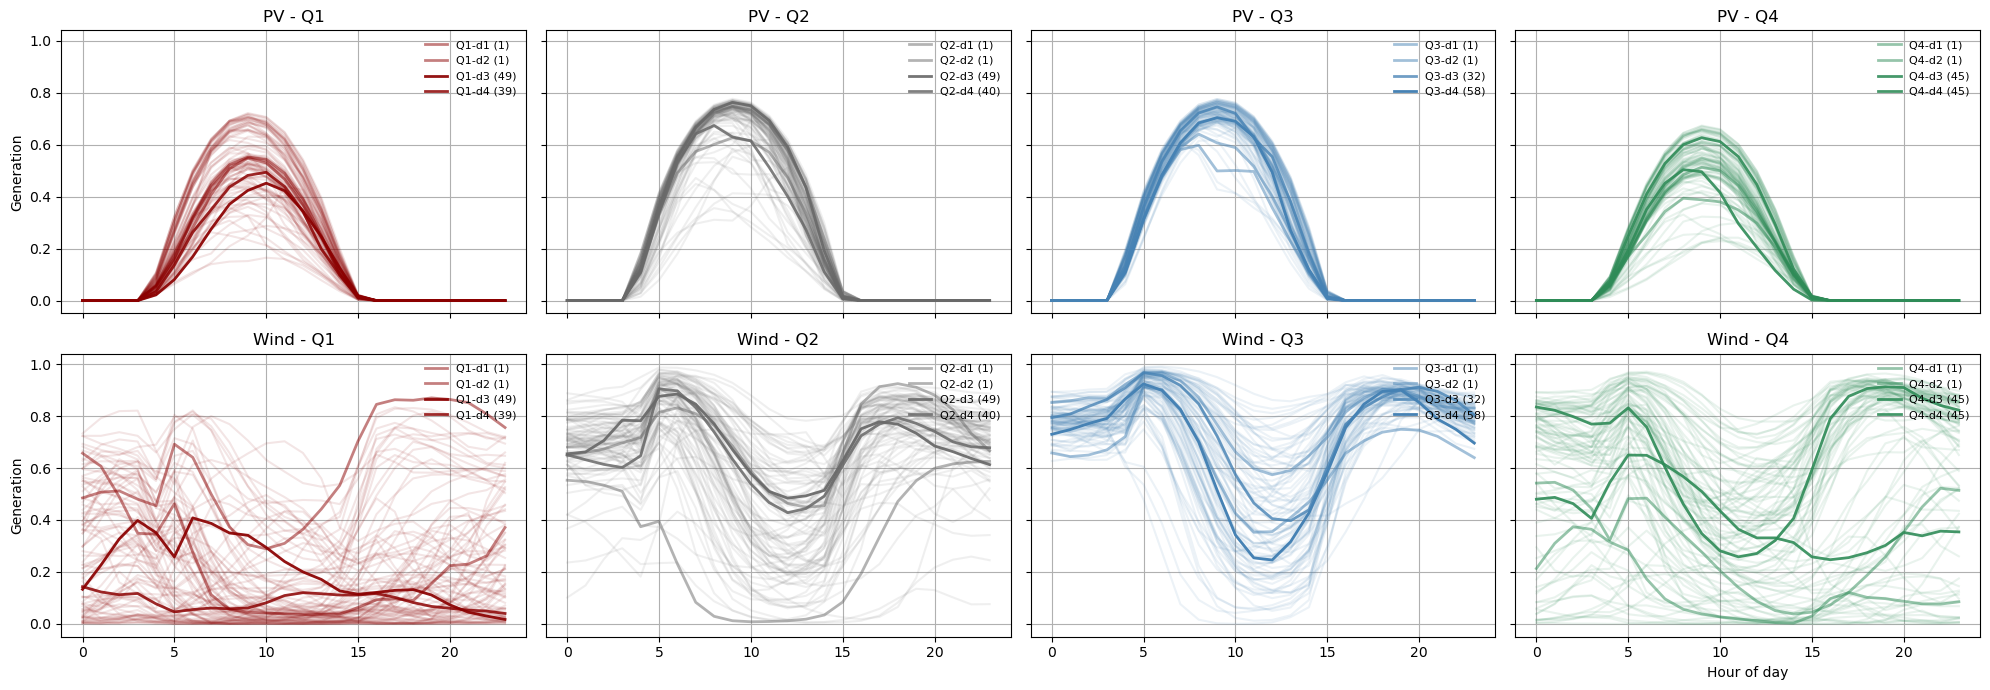

In [7]:
# Checking the representative days

# === SETTINGS ===
type = 'Load'  # can be 'PV', 'Wind', or 'Load'
rep_days = 'all'  # example: ['d1'] or 'all' or None
rep_days = ['d1']
color_types = {'PV': 'orange', 'Wind': 'lightblue', 'Load': 'steelblue'}
season_colors = {
    'Q1': 'darkred',
    'Q2': 'dimgrey',
    'Q3': 'steelblue',
    'Q4': 'seagreen'}

plot_vre_repdays(input_file=input_file, vre_profile=VREProfile, pHours=pHours,
          season_colors=season_colors, countries=['tanzania'], min_alpha=0.5, max_alpha=1)

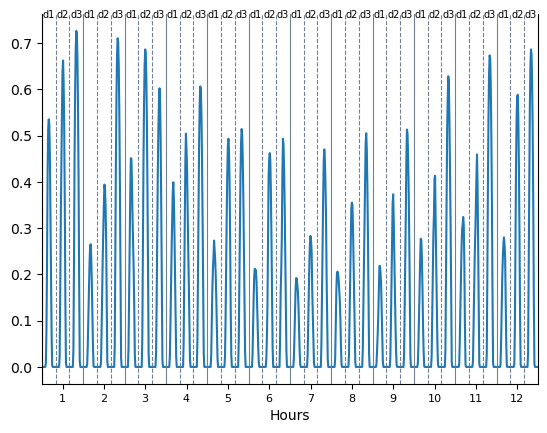

<Axes: xlabel='season'>

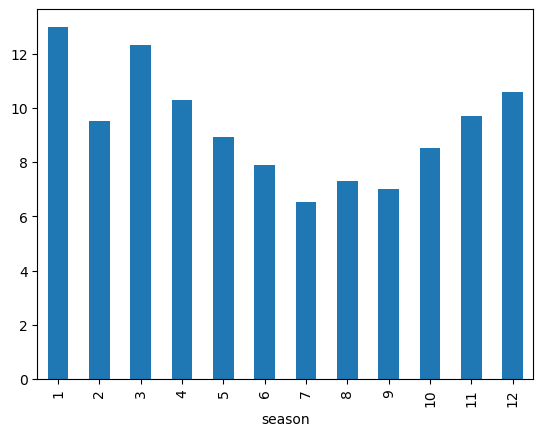

In [7]:
# Plot PV profile
path_file = os.path.join(main_folder, 'pVREProfile_{}.csv'.format(name_data))
df = pd.read_csv(path_file, index_col=[0, 1, 2, 3])
df = df.droplevel('zone', axis=0)
df = df.xs('PV', level='Power')
df = df.stack()
df.index.names = ['season', 'day', 'hour']
plot_dispatch(df)

df.groupby('season').sum().plot(kind='bar')


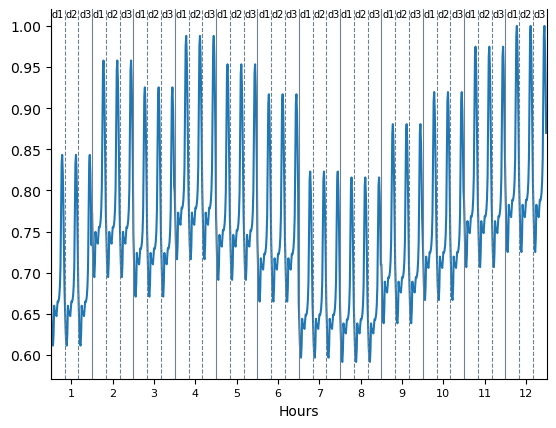

In [8]:
# Plot Demand profile
path_file = os.path.join(main_folder, 'pDemandProfile_{}.csv'.format(name_data))
df = pd.read_csv(path_file, index_col=[0, 1, 2])
df = df.droplevel('zone', axis=0)
df = df.stack()
df.index.names = ['season', 'day', 'hour']
plot_dispatch(df)